In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import datetime
import pickle

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [3]:
input_filename = 'temp/db'
articoli = pd.read_csv(input_filename, sep=";")
articoli['Data'] = articoli['Data'].astype('datetime64[ns]') 
del(articoli["Unnamed: 0"])

In [4]:
with open('stop_words', 'rb') as stopwords_dump:
    stop_words = pickle.load(stopwords_dump)

In [5]:
articoli.sample(1, random_state=0)

,ID,Titolo,Data,Testo,Trend,Txt,Anno,Mese,Day,Week,...,Words,ComputedTags,NumberOfTags,Application,Location,People,Tag,Vertical,Company,Tech
194,6bed2ed29fb43e18f87e26b68380e9eb,No-touch delivery platform protects against spreading viruses,2020-04-03,"Spotted: With more of us social distancing, staying at home and ordering necessities for delivery, it is not always easy to avoid contact with the courageous delivery workers who are keeping things moving. Logistics company AxleHire has developed a no-touch system to help with this issue.AxelHir...",Ecommerce and Digitalization of shops,touch delivery platform protects spreading viruses spotted social distancing staying home ordering necessities delivery always easy avoid contact courageous delivery workers keeping things moving logistics company axlehire developed touch help issue axelhire created suite tools enables consumers...,2020,4,3,14,...,"['app', 'delivery service', 'innovations', 'logistics', 'wellness']","Vertical: Wellness, Tag: Development, Application: Goods Delivery, Tech: Mobile app, Tag: Innovation",5,Goods Delivery,NaN,NaN,"Development, Innovation",Wellness,NaN,Mobile app


In [6]:
articoli.count()

ID              2170
Titolo          2170
Data            2170
Testo           2170
Trend           2170
Txt             2170
Anno            2170
Mese            2170
Day             2170
Week            2170
Keywords        2170
Words           2151
ComputedTags    2151
NumberOfTags    2170
Application     1000
Location         579
People            37
Tag             1560
Vertical        1687
Company          550
Tech            1012
dtype: int64

In [7]:
print ("Numero totale di trend: %d" % len(articoli['Trend'].unique()))

Numero totale di trend: 43


In [8]:
print ("Numero totale di combinazioni tecnologiche: %d" % len(articoli['Tech'].unique()))

Numero totale di combinazioni tecnologiche: 211


## All trends

In [9]:
unique_articoli_trend = articoli['Trend'].unique()

In [10]:
dummy_data=pd.get_dummies(articoli['Trend'])

list = []
for i in unique_articoli_trend:
    list.append(dummy_data[i].sum())

[Text(0.5, 0, 'Number of trends')]

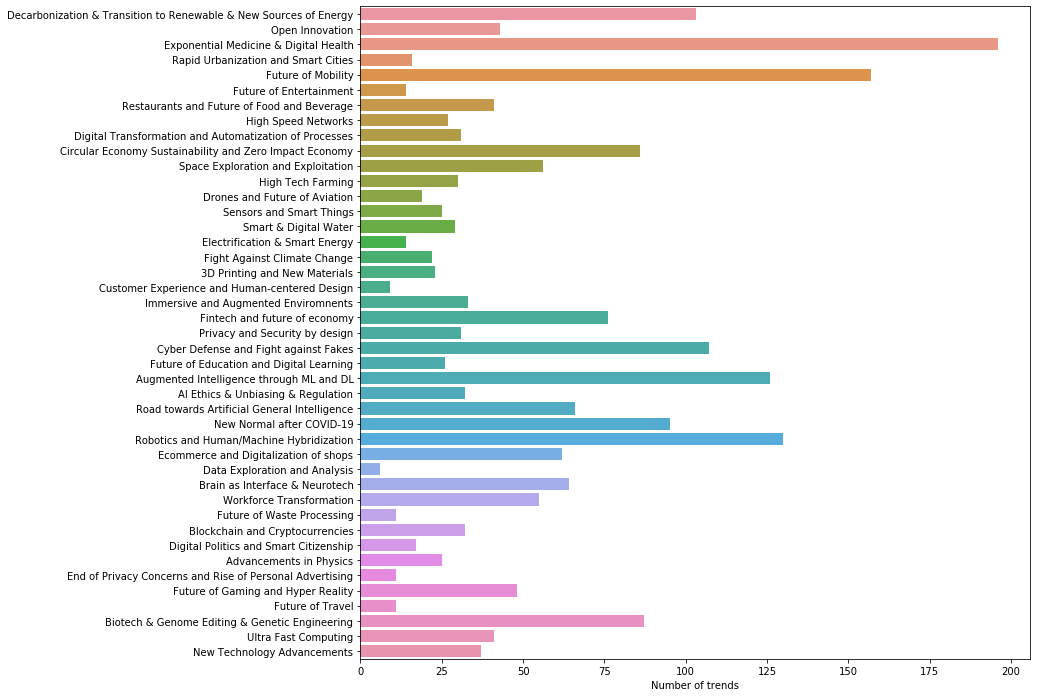

In [11]:
plt.figure(figsize=(12, 12))
ax=sns.barplot(y=unique_articoli_trend,x=list,data=articoli)
ax.set(xlabel='Number of trends')

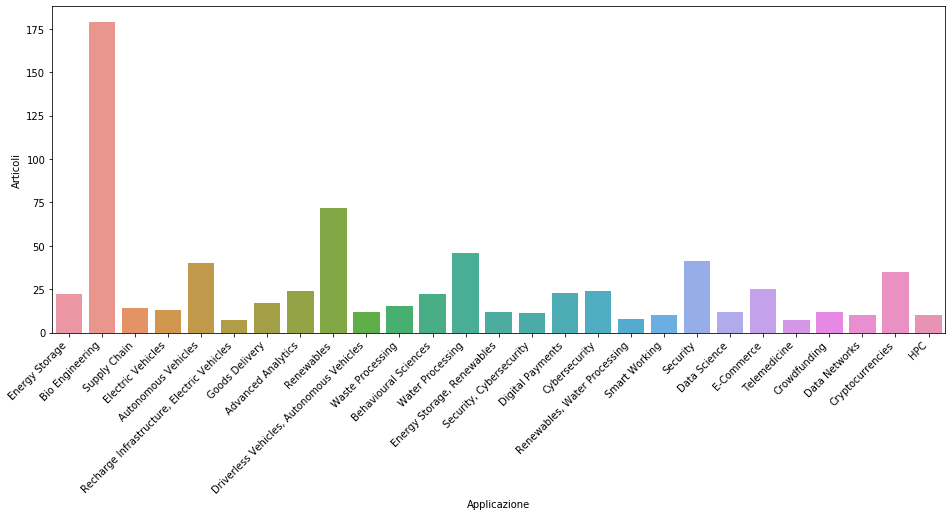

In [12]:
articoli['Application'].replace("", float('NaN'), inplace=True)
data = articoli.dropna(subset = ["Application"])
data = data[data.groupby('Application').Application.transform('count')>6].copy() 

plt.figure(figsize=(16,6))
ax=sns.countplot(data['Application'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")
plt.show()

## Technologies related to each trend

In [13]:
df = articoli.dropna(subset = ["Tech"]).set_index(data.columns.drop('Tech',1)
                    .tolist()).Tech.str.split(', ', expand=True).stack().reset_index().rename(columns={0:'Tech'})

In [14]:
pivot = pd.pivot_table(df, values=['Titolo'], index=['Trend'],
                   columns=['Tech'], aggfunc='count', margins=False)

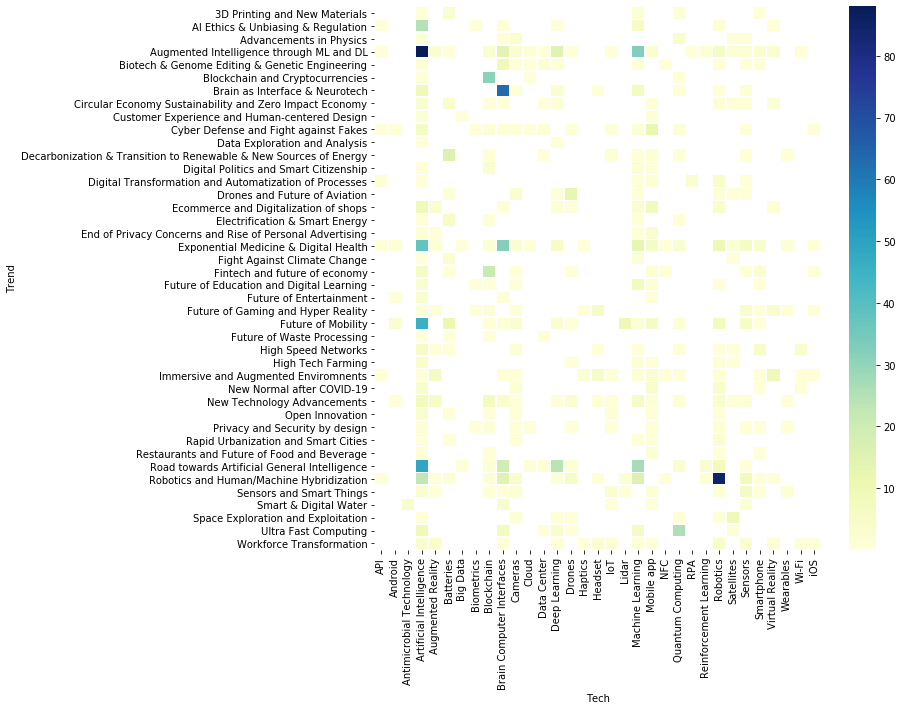

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(pivot['Titolo'],linewidths=.5,annot=False,vmin=0.01,cmap='YlGnBu')
#plt.title('Technologies related to each Trend')

## Vericals related to each trend

In [16]:
df = articoli.dropna(subset = ["Vertical"]).set_index(data.columns.drop('Vertical',1)
                    .tolist()).Vertical.str.split(', ', expand=True).stack().reset_index().rename(columns={0:'Vertical'})

In [17]:
pivot = pd.pivot_table(df, values=['Titolo'], index=['Trend'],
                   columns=['Vertical'], aggfunc='count', margins=False)

In [1]:
pivot

NameError: name 'pivot' is not defined

Text(0.5, 1, 'Verticals related to each Trend')

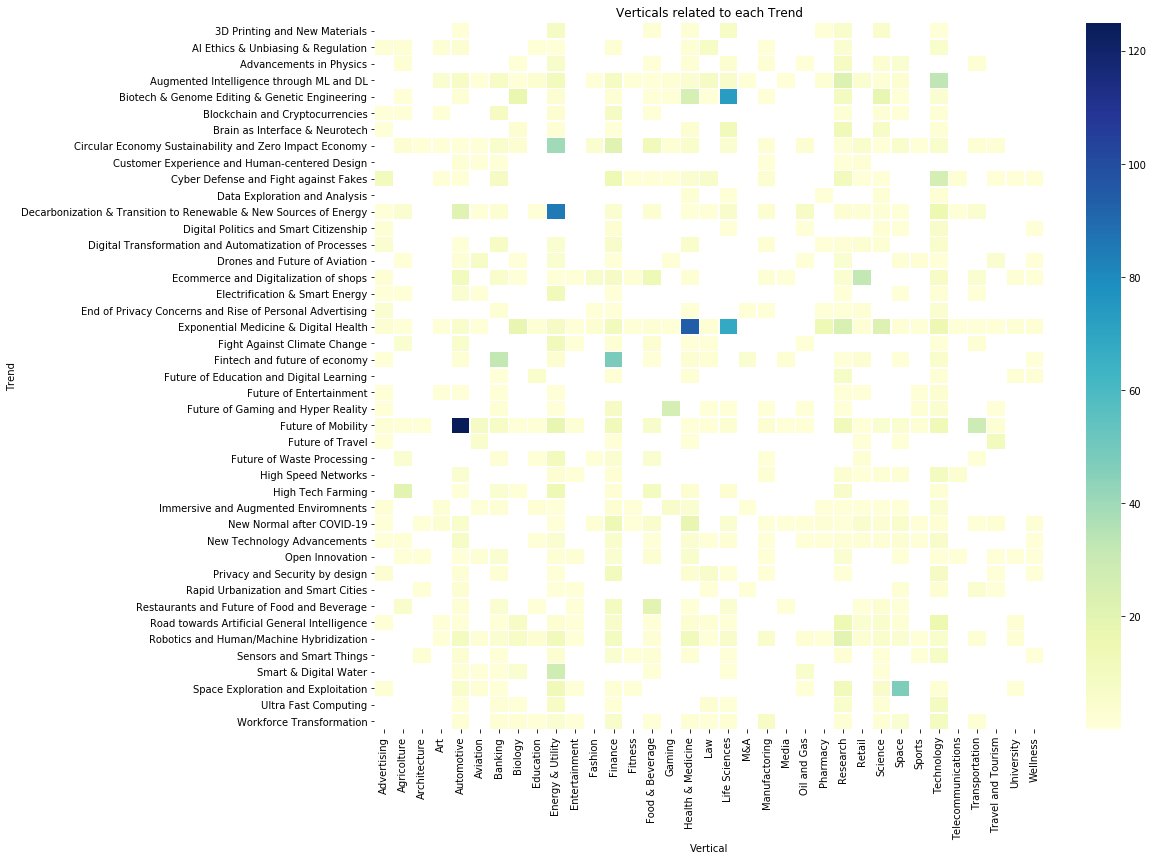

In [18]:
plt.figure(figsize=(15,13))
sns.heatmap(pivot['Titolo'],linewidths=.5,annot=False,vmin=0.01,cmap='YlGnBu')
plt.title('Verticals related to each Trend')

## Weekly articles for top verticals

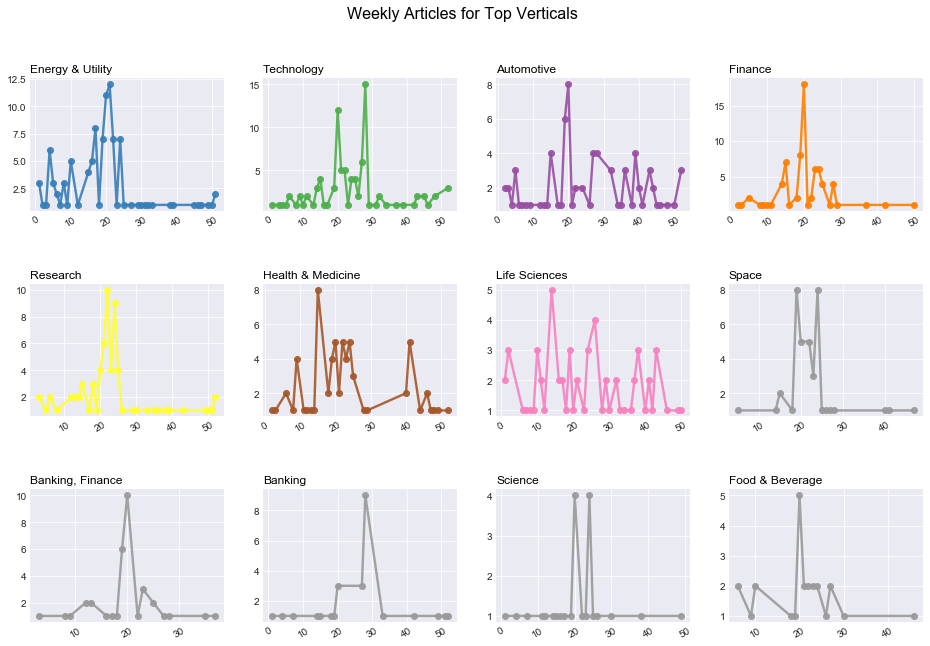

In [19]:
# https://python-graph-gallery.com/125-small-multiples-for-line-chart/
articles_per_vertical = articoli.groupby("Vertical").size().reset_index(name="Count").sort_values("Count", ascending=False)
articles_per_vertical['Vertical'].replace("", float('NaN'), inplace=True)
articles_per_vertical.dropna(subset = ["Vertical"], inplace=True)

# Initialize the figure
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,10))

# create a color palette
palette = plt.get_cmap('Set1')

n = 0
vertical = articles_per_vertical["Vertical"].unique()
df = articoli.groupby(["Week", "Vertical"]).size().reset_index(name="Count")
for i in vertical:
    n+=1

    d = df.loc[df['Vertical'] == i]
    plt.subplot(3,4, n)
    #plt.ylim(0,120)
    plt.plot(d['Week'], d['Count'], marker='o', color=palette(n), linewidth=2.4, \
             alpha=0.9, label=i)
    plt.xticks(rotation=30)
    plt.title(i, loc='left', fontsize=12, fontweight=0, color="black" )
    
    if n == 12:
        break

# general title
plt.suptitle("Weekly Articles for Top Verticals", fontsize=16, fontweight=0, color='black')
plt.subplots_adjust(hspace=0.55)

## Weekly articles for top tech

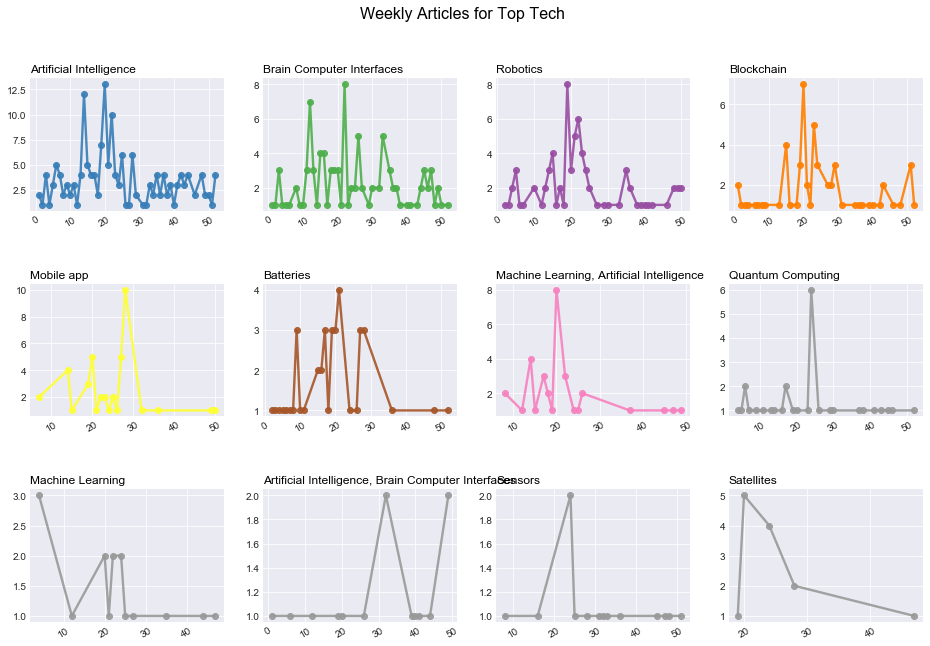

In [20]:
# https://python-graph-gallery.com/125-small-multiples-for-line-chart/
articles_per_tech = articoli.groupby("Tech").size().reset_index(name="Count").sort_values("Count", ascending=False)
articles_per_tech['Tech'].replace("", float('NaN'), inplace=True)
articles_per_tech.dropna(subset = ["Tech"], inplace=True)

# Initialize the figure
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,10))

# create a color palette
palette = plt.get_cmap('Set1')

n = 0
vertical = articles_per_tech["Tech"].unique()
df = articoli.groupby(["Week", "Tech"]).size().reset_index(name="Count")
for i in vertical:
    n+=1

    d = df.loc[df['Tech'] == i]
    plt.subplot(3,4, n)
    #plt.ylim(0,120)
    plt.plot(d['Week'], d['Count'], marker='o', color=palette(n), linewidth=2.4, \
             alpha=0.9, label=i)
    plt.xticks(rotation=30)
    plt.title(i, loc='left', fontsize=12, fontweight=0, color="black" )
    
    if n == 12:
        break

# general title
plt.suptitle("Weekly Articles for Top Tech", fontsize=16, fontweight=0, color='black')
plt.subplots_adjust(hspace=0.55)

## Top tags

Text(0.5, 0, 'Occurrencies')

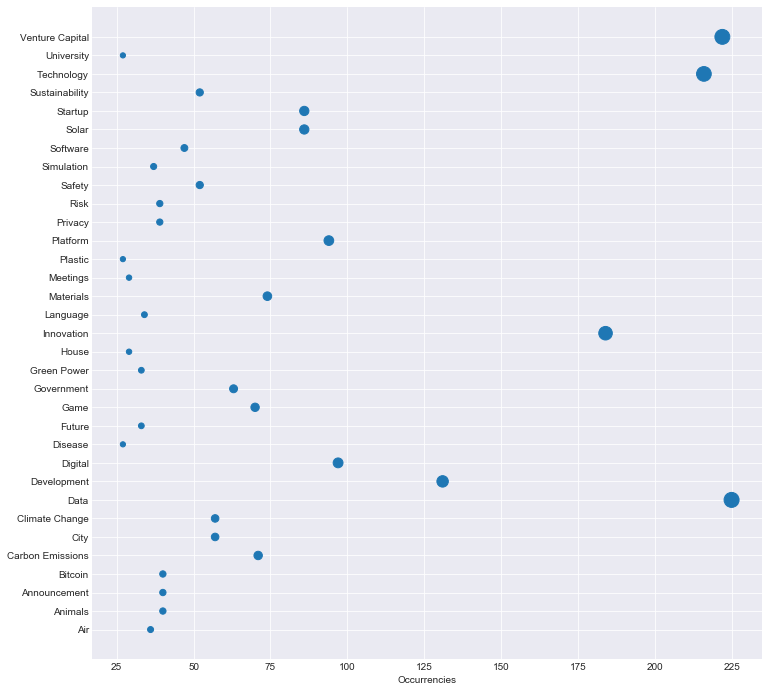

In [21]:
df = articoli[['Trend', 'Tag']]
df = df.replace(np.nan, '', regex=True)
df = df[~(df['Tag'].str.len() == 0)]

df = pd.concat([pd.Series(row['Trend'], row['Tag'].split(', '))              
                    for _, row in df.iterrows()]).reset_index().rename(columns={"index": "Tag", 0: "Trend"})

df = df.groupby(["Tag"]).size().reset_index(name="Count")
df.sort_values("Tag", ascending=False)
df = df[df['Count']>25].copy() 

plt.figure(figsize=(12, 12))
plt.scatter('Count', 'Tag', s="Count", data=df)
plt.xlabel('Occurrencies')

## Top applications

Text(0.5, 0, 'Occurrencies')

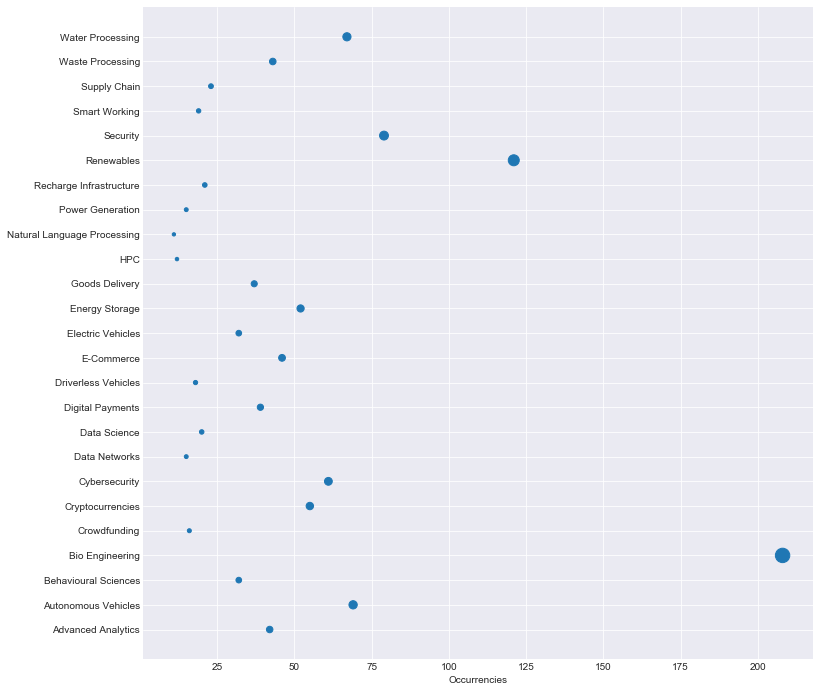

In [22]:
df = articoli[['Trend', 'Application']]
df = df.replace(np.nan, '', regex=True)
df = df[~(df['Application'].str.len() == 0)]

df = pd.concat([pd.Series(row['Trend'], row['Application'].split(', '))              
                    for _, row in df.iterrows()]).reset_index().rename(columns={"index": "Application", 0: "Trend"})

df = df.groupby(["Application"]).size().reset_index(name="Count")
df.sort_values("Application", ascending=False)
df = df[df['Count']>10].copy() 

plt.figure(figsize=(12, 12))
plt.scatter('Count', 'Application', s="Count", data=df)
plt.xlabel('Occurrencies')

## Top technologies

Text(0, 0.5, 'Tech')

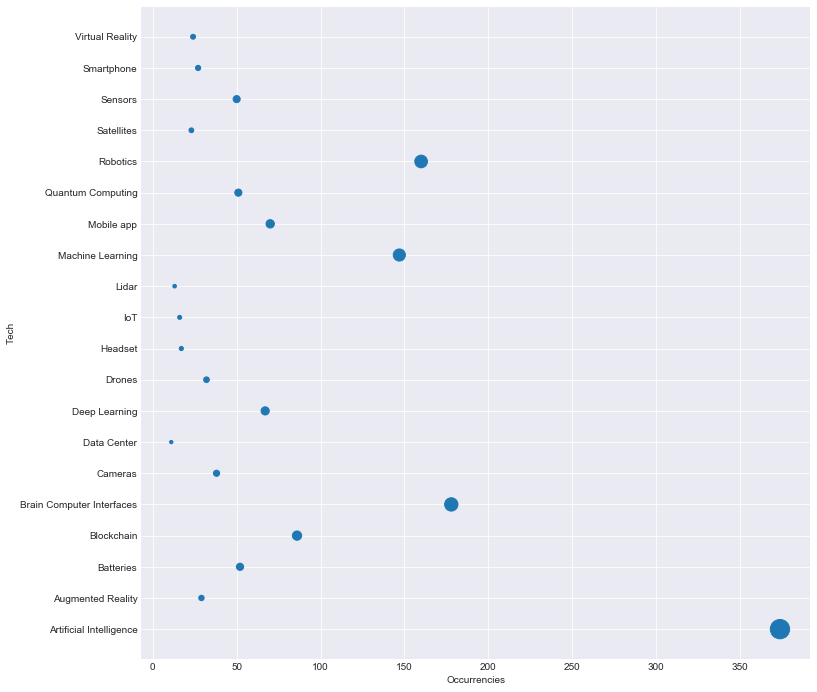

In [23]:
df = articoli[['Trend', 'Tech']]
df = df.replace(np.nan, '', regex=True)
df = df[~(df['Tech'].str.len() == 0)]

df = pd.concat([pd.Series(row['Trend'], row['Tech'].split(', '))              
                    for _, row in df.iterrows()]).reset_index().rename(columns={"index": "Tech", 0: "Trend"})

df = df.groupby(["Tech"]).size().reset_index(name="Count")
df = df[df['Count']>10].copy() 
df.sort_values("Tech", ascending=False)

plt.figure(figsize=(12, 12))
plt.scatter('Count', 'Tech', s="Count", data=df)
plt.xlabel('Occurrencies')
plt.ylabel('Tech')

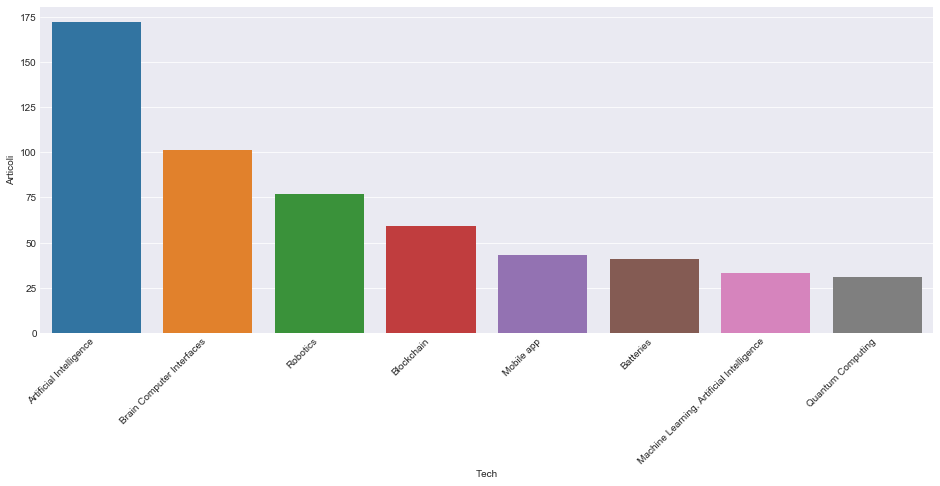

In [24]:
sub_df = articoli[articoli.groupby('Tech').Tech.transform('count')>20].copy() 
sub_df['Tech'].replace("", float('NaN'), inplace=True)
data = sub_df.dropna(subset = ["Tech"])

plt.figure(figsize=(16,6))

ax = sns.countplot(x = 'Tech',
              data = data,
              order = data['Tech'].value_counts().index)


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Tech")
plt.show()

## Top verticals

Text(0.5, 0, 'Occurrencies')

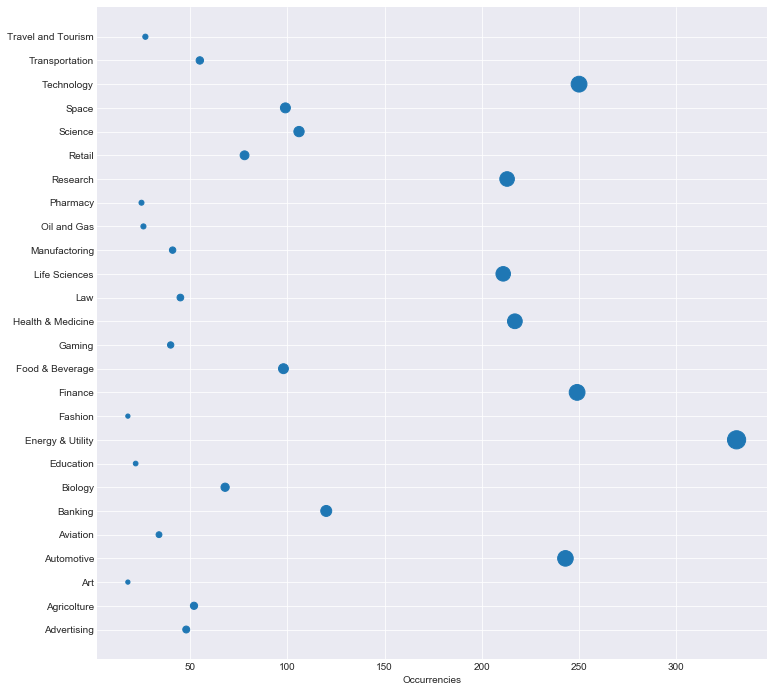

In [25]:
df = articoli[['Trend', 'Vertical']]
df = df.replace(np.nan, '', regex=True)
df = df[~(df['Vertical'].str.len() == 0)]

df = pd.concat([pd.Series(row['Trend'], row['Vertical'].split(', '))              
                    for _, row in df.iterrows()]).reset_index().rename(columns={"index": "Vertical", 0: "Trend"})

df = df.groupby(["Vertical"]).size().reset_index(name="Count")
df = df[df['Count']>15].copy() 
df.sort_values("Vertical", ascending=False)

plt.figure(figsize=(12, 12))
plt.scatter('Count', 'Vertical', s="Count", data=df)
plt.xlabel('Occurrencies')

## Prove a caso

In [26]:
## Prove a caso

In [27]:
articoli['NumberOfTags']

0       9
1       3
2       4
3       5
4       2
       ..
2165    6
2166    5
2167    7
2168    4
2169    7
Name: NumberOfTags, Length: 2170, dtype: int64

In [28]:
df = articoli[(articoli['NumberOfTags'] < 2)]

In [29]:
df = df[['ID', 'Titolo', 'Words', "NumberOfTags"]]

In [30]:
df.head()

,ID,Titolo,Words,NumberOfTags
78,02de4f1b7462ab871ed18c7defd8df60,How Can I Save Planet Earth?,NaN,0
127,e0068e68d7137e050a63cf0279f691fd,The Rad Power Bikes RadRover Step-Thru E-Bike Is A Beast On Or Off Road (Review),['power'],1
130,3f02ee96b6d71fdf79b02094c8f2e206,Goodyear's biodegradable concept tire regenerates its tread,['materials'],1
165,e7e564f08b9318ed6ded32f872bddbd8,Coronavirus and the campus: How can US higher education organize to respond?,['universities'],1
180,59682ae5330ffad755fafe80c3ce0e87,Getting ahead of the next stage of the coronavirus crisis,NaN,0


In [31]:
df.count()

ID              155
Titolo          155
Words           136
NumberOfTags    155
dtype: int64

In [32]:
## Technologies related to each trenddf = articoli[['ID', 'Titolo','Data', 'Trend', 'Vertical', 'Tech']]

In [33]:
df.count()

ID              155
Titolo          155
Words           136
NumberOfTags    155
dtype: int64

In [34]:
df = df.replace(np.nan, '', regex=True)
df = df[~(df['Vertical'].str.len() == 0)]

KeyError: 'Vertical'

In [ ]:
df.count()

In [ ]:
df['pca'] = (
            df['Titolo']
            .pipe(hero.clean)
            .pipe(hero.tfidf)
            .pipe(hero.pca)
   )

In [ ]:
hero.scatterplot(df, col='pca', color="Vertical")

In [ ]:
df.head()

In [ ]:
df = articoli[['Data', 'Trend']]

In [ ]:
def split_trends_in_columns(trend, column):
    if trend == column:
        return 1
    
    return 0
    
list = df['Trend'].unique().tolist()
for tt in list:
    df[tt] = df['Trend'].apply(lambda x: split_trends_in_columns(x, tt))

In [ ]:
df.head()

In [ ]:
#df = df.set_index('Data')

In [ ]:
#df['Year'] = df.index.year
#df['Month'] = df.index.month

In [ ]:
df1 = articoli[['Data', 'Trend']].groupby(["Data", "Trend"]).size().reset_index(name="Count")
df1.sort_values(by=['Data'], inplace=True)
df1 = df1.set_index('Data')

In [ ]:
df1.head()

In [ ]:
#df1.to_csv('prova.csv', sep=";")

In [ ]:
df1 = df1[~(df1['Count'] == 0)]

In [ ]:
def split_trends_in_columns(trend, count, column):
    if trend == column:
        return count
    
    return 0

list = df1['Trend'].unique().tolist()
for tt in list:
    df1[tt] = df1.apply(lambda x: split_trends_in_columns(x['Trend'], x['Count'], tt), axis=1)

In [ ]:
df1.head()

In [ ]:
cols_plot = ['Health Tech', 'Ecommerce and Digitalization of shops', 'Smart & Digital Water']

In [ ]:
df1c = df1[cols_plot]
for c in cols_plot:
    df1c = df1c[~(df1c[c] == 0)]

In [ ]:
df1c.head()

In [ ]:
cols_plot = ['Fintech and future of economy']

for c in cols_plot:
    df1 = df1[~(df1[c] == 0)]

In [ ]:
df1.head()

In [ ]:
cols_plot = ['Health Tech', 'Ecommerce and Digitalization of shops', 'Smart & Digital Water']
axes = df1[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Articles')

In [ ]:
start, end = '2019-05', '2020-05'
cols_plot = ['Health Tech', 'Ecommerce and Digitalization of shops', 'Smart & Digital Water']

sns.set(rc={'figure.figsize':(12, 6)})
fig, ax = plt.subplots()

for c in cols_plot:
    ax.plot(df1.loc[start:end, c], marker='.', linestyle='none', linewidth=0.5, label=c)

ax.legend()
plt.show()

In [ ]:
df2 = articoli[['Anno', 'Trend']].groupby(["Anno", "Trend"]).size().reset_index(name="Count")
df2.sort_values(by=['Anno'], inplace=True)
#df2 = df2.set_index('Anno')

In [ ]:
df2.head(20)

In [ ]:
ax = df2.plot(kind='scatter',x='Trend',y='Anno',color='red')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [ ]:
df3 = articoli[['Anno', 'Trend']].groupby(["Anno", "Trend"]).size().reset_index(name="Count")
df3.sort_values(by=['Anno'], inplace=True)

In [ ]:
df3.head()

In [ ]:
list = df3['Trend'].unique().tolist()
for tt in list:
    df3[tt] = df3.apply(lambda x: split_trends_in_columns(x['Trend'], x['Count'], tt), axis=1)

In [ ]:
df3.head()

In [ ]:
df3.count()

In [ ]:
df3_ht = df3[['Anno','Health Tech']]
df3_ht = df3_ht[~(df3_ht['Health Tech'] == 0)]

ax = plt.gca()

ax = df3_ht.plot(kind='scatter',x='Health Tech',y='Anno',color='red' ,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
df.head()

In [ ]:
trend_by_date = df.groupby(["Data"]).size().reset_index(name="Count").sort_values("Count", ascending=False)

In [ ]:
trend_by_date = trend_by_date.set_index('Data')

In [ ]:
trend_by_date.head()

In [ ]:
sns.set(rc={'figure.figsize':(11, 4)})
trend_by_date.plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9));

In [ ]:
trend_by_date = articoli[['Data', 'Trend']].rename(columns={"Data": "publish_date", "Titolo": "headline_text"})
trend_by_date.set_index('publish_date')
trend_by_date.head()

In [ ]:
trend_by_date.index

In [ ]:
#df1 = trend_by_date.set_index('publish_date').groupby('Trend').resample('1D')['Trend'].ffill()

In [ ]:
#articles_per_vertical = articoli.groupby("Vertical")
#.size().reset_index(name="Count").sort_values("Count", ascending=False)

In [ ]:
trend_by_date = articoli[['Data', 'Trend']].groupby(["Data", "Trend"]).size().reset_index(name="Count").sort_values("Count", ascending=False)

In [ ]:
trend_by_date.head()

In [ ]:
#trend_by_date['Trend'].unique().tolist()
def split_trends_in_columns(trend, column):
    if trend == column:
        return 1
    
    return 0
    
    
#trend_by_date[] = split_trends_in_columns(trend_by_date['Trend'][0], "Fintech and future of economy")
#split_trends_in_columns(trend_by_date['Trend'][0], "Advancements in Physics")

trend_by_date["Advancements in Physics"] = articoli['Trend'].apply(lambda x: split_trends_in_columns(x, "Advancements in Physics"))

In [ ]:
trend_by_date.head()

In [ ]:
articoli['Tech'].replace("", float('NaN'), inplace=True)
data = articoli.dropna(subset = ["Tech"])
data = data[data.groupby('Tech').Tech.transform('count')>6].copy() 
data['Vertical'].replace("", float('NaN'), inplace=True)
data = data[data['Vertical'] == "Energy & Utility"]


plt.figure(figsize=(16,6))
ax=sns.countplot(data['Tech'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Tech")
plt.suptitle("Tech in Energy & Utility", fontsize=16, fontweight=0, color='black')
plt.show()

In [ ]:
articoli['Location'].replace("", float('NaN'), inplace=True)
data = articoli.dropna(subset = ["Location"])
data = data[data.groupby('Location').Location.transform('count')>8].copy() 

plt.figure(figsize=(16,6))
ax=sns.countplot(data['Location'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Location")
plt.show()

In [ ]:
from wordcloud import WordCloud

def print_wordcloud(corpus):
    wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))

    fig = plt.figure(1)
    plt.figure(figsize=(10,10)) 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [ ]:
print_wordcloud(articoli['Txt'])

In [ ]:
# Initialize the figure
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,10))

# create a color palette
palette = plt.get_cmap('Set1')

mesi = articoli['Mese'].unique()

n = 0
for i in mesi:
    n+=1
    corpus = articoli[articoli["Mese"] == i]

    wordcloud = WordCloud(
                      background_color='white',
                      stopwords=stop_words,
                      max_words=50,
                      max_font_size=40, 
                      random_state=42
                     ).generate(str(corpus['Txt']))

    plt.subplot(2,2, n)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(str("Tag Cloud mese %d" % i), loc='left', fontsize=12, fontweight=0, color="black" )
    #plt.show()
    
    if n == 4:
        break

plt.suptitle("Monthly Tag Cloud", fontsize=16, fontweight=0, color='black')
plt.subplots_adjust(hspace=0.5)

In [ ]:
trend_week = articoli.groupby(["Trend", "Anno", "Week", "Tech"]).size().reset_index(name="Count")
#trend_week['Data']=trend_week.apply(lambda x:'%sw%s' % (x['Anno'],x['Week']),axis=1)
trend_week.head()

In [ ]:
cols = ["Anno", "Mese", "Vertical"]
df = articoli.groupby(cols).size().reset_index(name="Count").sort_values("Count", ascending=False)
df = df[df['Anno'] == 2020]
df = df[df['Count']>6].copy() 
df.head()

In [ ]:
plt.figure(figsize=(12, 12))
plt.scatter('Mese', 'Vertical', s="Count", data=df)
plt.xlabel('Mese')
plt.ylabel('Vertical')

In [ ]:
# Generate a Boxplot
plt.figure(figsize=(12, 9))
sns.boxplot( x=df["Mese"], y=df["Vertical"] )

In [ ]:
def num_missing(x):
  return sum(x.isnull())

print ("Missing values per column:")
print (articoli.apply(num_missing, axis=0) )#axis=0 defines that function is to be applied on each column

In [ ]:
import texthero as hero

In [ ]:
from texthero import preprocessing

custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace]
articoli['clean_text'] = hero.clean(articoli['Testo'])

In [ ]:
articoli['tfidf_clean_text'] = hero.tfidf(articoli['clean_text'])

In [ ]:
articoli['pca'] = (
            articoli['Testo']
            .pipe(hero.clean)
            .pipe(hero.tfidf)
            .pipe(hero.pca)
   )

In [ ]:
articoli.head()

In [ ]:
hero.scatterplot(articoli, col='pca', color="Trend")

In [ ]:
df = articoli[['ID', 'Titolo','Data', 'Trend', 'Vertical', 'Tech']]

In [ ]:
df.count()

In [ ]:
df = df.replace(np.nan, '', regex=True)
df = df[~(df['Vertical'].str.len() == 0)]

In [ ]:
df.count()

In [ ]:
df['pca'] = (
            df['Titolo']
            .pipe(hero.clean)
            .pipe(hero.tfidf)
            .pipe(hero.pca)
   )

In [ ]:
hero.scatterplot(df, col='pca', color="Vertical")

In [ ]:
df.head()